## Tips & tricks 1 : unsolvable

In this model, we will show how to help making a problem solvable.

####  Base model

In this model, we have a power unit trying to supply a load going either below the p_min, and above the p_max. The problem therefore cannot be solved.

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from eesrep import Eesrep
from eesrep.components.sink_source import FatalSink, FatalSource, Sink, Source
from eesrep.components.storage import GenericStorage
from eesrep.eesrep_exceptions import UnsolvableProblemException

In [2]:
model = Eesrep(interface="docplex")

load_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [0 if i < 20 else 300 for i in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = load_df)

power_unit = Source(name="power_unit", 
                        p_min = 50., p_max=150., price = 0.)

model.add_component(power_unit)
model.add_component(load)

model.create_bus(bus_type = "bus", 
                    options = {
                                "name":"bus_1"
                            })
                        
model.plug_to_bus(io = power_unit.power_out, bus_name = "bus_1", is_input = True, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_name = "bus_1", is_input = False, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
try:
    model.solve()
except UnsolvableProblemException:
    print("The problem is not solvable!")

Running first time step
The problem is not solvable!


####  Tweaked model

We can add two components to the model:

-   Spilled : a Sink component that will take out the excess of power;
-   Unsupplied : a Source component that will supply the missing energy to close the system.

Both component operate at a very high price per energy unit, compared to other producion means in the system, so they will be called last. Adding these components to complex buses can help considerably solve the system, even though it would be solvable without them. 

In [3]:
model = Eesrep(interface="docplex")

load_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [0 if i < 20 else 300 for i in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = load_df)

power_unit = Source(name="power_unit", 
                        p_min = 50., p_max=150., price = 0.)
                        
spilled = Sink(name="spilled", p_min = 0., p_max = None, price=100000.)
unsupplied = Source(name="unsupplied", p_min = 0., p_max = None, price=100000.)

model.add_component(power_unit)
model.add_component(load)
model.add_component(spilled)
model.add_component(unsupplied)

model.create_bus(bus_type = "bus", 
                    options = {
                                "name":"bus_1"
                            })
                        
model.plug_to_bus(io = power_unit.power_out, bus_name = "bus_1", is_input = True, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_name = "bus_1", is_input = False, factor=1., offset=0.)

model.plug_to_bus(io = spilled.power_in, bus_name = "bus_1", is_input = False, factor=1., offset=0.)
model.plug_to_bus(io = unsupplied.power_out, bus_name = "bus_1", is_input = True, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


We can see below that the expected behavior is now respected, with a negligible change of total price.

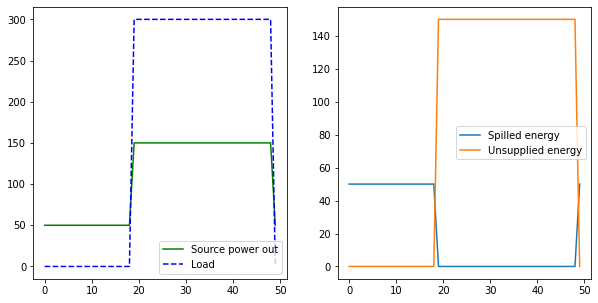

In [4]:
results = model.get_results(as_dataframe=False)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["power_unit"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="blue")
plt.legend()
plt.subplot(122)
plt.plot(results["spilled"]["power_in"], label = "Spilled energy")
plt.plot(results["unsupplied"]["power_out"], label = "Unsupplied energy")
plt.legend()
plt.show()